module imports

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

load data

In [11]:
# loading MNIST

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = torchvision.datasets.MNIST(root = './MNISTdata', train = True, download = True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4)

testset = torchvision.datasets.MNIST(root = './MNISTdata', train = False, download = True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4)

In [12]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_1')

In [13]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

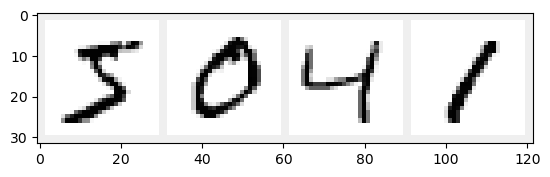

In [14]:
# writing an image to the Tensorboard

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_mnist_images', img_grid)

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
# Load one batch to check the shape
dataiter = iter(train_loader)
images, labels = next(dataiter)

print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: torch.Size([4, 1, 28, 28])
Label batch shape: torch.Size([4])


"math": 
- MNIST is initially 28 x 28 x 1 (1 channel) -> (1, 28, 28)
- after conv1, kernel size = 3, stride = 1 -> (32 * 26 * 26), because 28 - 3 + 1 = 26
- after conv2, kernel size = 3 -> (64 * 24 * 24), because 26 - 3 + 1 = 24
- after maxPool, spatial dimensions become halved -> 64 * 12 * 12 = 9216 features 

model definition

In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        #
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.pool(x)
        
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output
        

In [18]:
convNet = CNN()

optimizer = torch.optim.Adam(convNet.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

training step

In [19]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # data is a list of [inputs, labels]
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = convNet(inputs)
        loss = criterion(outputs, labels)
        
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print("Finished Training")
writer.flush()
writer.close()

[1,  2000] loss: 2.309
[1,  4000] loss: 2.305
[1,  6000] loss: 2.305
[1,  8000] loss: 2.305
[1, 10000] loss: 2.305
[1, 12000] loss: 2.305
[1, 14000] loss: 2.306
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.305
[2,  8000] loss: 2.305
[2, 10000] loss: 2.305
[2, 12000] loss: 2.305
[2, 14000] loss: 2.306
Finished Training


In [20]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [21]:
test(convNet, "cpu", test_loader)


Test set: Average loss: 2.3020, Accuracy: 1028/10000 (10%)

